<a href="https://colab.research.google.com/github/TheRadDani/QML/blob/main/Module_4_Machine_learning_fine_tuning_quantum_dots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Machine learning for fine-tuning of quantum dots

### Table of Contents

* [1. Machine learning on quantum parameter estimation](#part1)
    * [1.1. Physics background](#Step_1)
    * [1.2. Import data and analyze the data shape](#Step_2)
    * [1.3. Prepare data](#Step_3)
    * [1.4. Setup the model](#Step_4)
    * [1.5. Train the model](#Step_5)
    * [1.6. Interpretation and analysis](#Step_6)
    
    
* [2. Exercise](#part2)

## 1.  Machine learning on quantum parameter estimation <a class="anchor" id="part1"></a>
<!-- - Reference: PhysRevLett.118,177702;
- PhysRevLett.101.236803
 -->
We have learnt from the lecture that there exists a well defined qubit on a double quantum dot. However, in quantum dots made from materials with nonzero nuclear spins, the hyperfine coupling creates a fluctuating effective Zeeman field (Overhauser field) between electron spins and nuclear spins. This Overhauser field can be a dominant source of qubit decoherence because the Overhauser magnetic field influences the axis of the qubit precession. [Fig 1c]

*Goal: Using neural networks to learn the Overhauser magnetic field, from the precession of the qubit. Then we can use it for compensation during qubit operations.*

### 1.1 Physics background <a class="anchor" id="Step_1"></a>
##### Challenges
- We want to achieve precise control of electron spins in gate-defined quantum dots. For instance on GaAs.
- However, the host lattice has spinful nuclei that couple to electron spins via the hyperfine interaction.
- The Overhauser field, produced by nuclear spins in the host crystal, undergos their own dynamics due to their mutual dipole-dipole coupling. These dynamics lead to fluctuations of the longitudinal Overhauser field, which in turn affect the evolution of the qubit that we want to control precisely.

- In turn, the qubit operation and readout technology allow us to inversely probe the electron-plus-nuclear environment system.
    - The precession of the qubit in the Overhauser field gradient will give the singlet-triplet oscillations.
    - The time evolution of the qubit precession frequency, $f_{Ovh}$, is then extracted from the singlet-triplet oscillations.
    - The frequency corresponds to the absolute value of the Overhauser field gradient $|\Delta B_{\parallel}|$.

- In this notebook, we train a neural network to learn the magnetic Overhauser field from the precession of electron spins.
---
#### Qubit basics
The qubit is defined in a two-electron double quantum dot [Fig. 1(a)]. The external magnetic field $B_{ext}$ separates the qubit states to the singlet,
$$
|S\rangle = \frac{1}{\sqrt{2}}(|\uparrow\downarrow\rangle - |\uparrow\downarrow\rangle),
$$
and the unpolarized triplet,
$$
|T_0\rangle = \frac{1}{\sqrt{2}}(|\uparrow\downarrow\rangle + |\uparrow\downarrow\rangle),
$$
from the fully polarized triplet state $T_{+} = |\uparrow\uparrow\rangle$ and $T_{-} = |\downarrow\downarrow\rangle$. In this notation, the first (second) arrow indicates the electron spin in the left (right) dot. The resulting energy diagram of the spin states at the transition between $(1,1)$ and $(2,0)$ charge states is presented in Fig. 1(b). Here (N, M) indicates the number of electrons in the left ($N$) and the right ($M$) dot. The Bloch sphere representation of the qubit is shown in Fig. 1(c), where the axis of the qubit precession is controlled by the Overhauser field gradient component $\Delta B_{||}$.

![Alt Text](https://journals.aps.org/prl/article/10.1103/PhysRevLett.118.177702/figures/1/medium)
<div align="center"> Fig.1 [PhysRevLett.118,177702]

In the simplified senario, the dynamics of the $S − T_0$ oscillation in the well-separated $(1,1)$ charge state is governed by the static external magnetic field and dynamic Overhauser fields. For the pedagogical purpose, we consider the large external magnetic field $B_{ext}$ and use the simplified qubit evolution with the Hamiltonian
    
$$
\hat{H}(t) = 2\pi \sum_{i=L,R} (\Delta B_{||}(t)) \hat{\sigma}_z^{i},
$$
    
where $\hat{\sigma}_z^{i}$ is the spin operator of the electron in left or
right dot with $i = \{L, R\}$. $\Delta B_{||}(t)$ is the Overhauser field gradient component parallel to static external magnetic field $B_{ext}$.
    
*Take home message: The splitting between qubit states $|\downarrow\uparrow\rangle$ and $|\uparrow\downarrow\rangle$ is proportional to the longitudinal component of the Overhauser field gradient, $\Delta B_{||} = B^{L}_{||} -B^{R}_{||} $ , and can be measured by monitoring the oscillation between $|S\rangle$ and $|T_0\rangle$.*

#### Experiment protocols

To measure this oscillation between $|S\rangle$ and $|T_0\rangle$, we apply a cyclic pulse sequence that first prepares the singlet $|S\rangle$ , then separates the two electrons to allow free precession in the Overhauser field for time $t_S$, and, finally, performs a projective readout of the qubit in the $S$ − $T_0$ basis [Fig. 1(d)]
- For each $t_S$ we use 16 single-shot readouts of this sequence to estimate the singlet return probability $P_S$.
- Repeatedly sweeping Qubit precession time $t_S$ from $0$ to $250 ns$ in 300 steps allows the precession of the qubit in the evolving Overhauser field to be measured with roughly  $1 s$ temporal resolution.
- A time trace showing $80 s$ of slow-mode probability data is shown in Fig. 2(a).
-  The time evolution of the qubit precession frequency, $f_{Ovh}(t)$, is then extracted from these data.
- The frequency corresponds to the absolute value of the Overhauser field gradient
$$
|\Delta B_{||}(t)| \propto h f_{Ovh}(t)
$$
- Examples of $|\Delta B_{||}(t)|$ for $B_{ext} = 0.2 T$ are shown in Figs. 2(a), 2(b).

![Alt Text](https://journals.aps.org/prl/article/10.1103/PhysRevLett.118.177702/figures/2/medium)
<div align="center"> Fig.2 [PhysRevLett.118,177702]
    
- Each $S − T_0$ oscillation at a specific Overhauser field is represented by a column in Fig.2(a),(b) upper panel.
    
- We use the neural networks to learn the Overhauser field from the $S − T_0$ oscillation. The inputs are the singlet return probability, $P_S$, which is formed into an array of length - 800 steps in the Quibt precession time $t_S$. The output is the Overhauser field $|\Delta B_{||}(t)|$.

### 1.2. Import data and analyze the data shape <a class="anchor" id="Step_2"></a>

In [ ]:
### Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Machine learning related libraries:
import torch
import torch.nn as nn            # base class used to develop all neural network models
import torch.nn.functional as F  # module of relu activation functions
import torch.optim as optim      # module of Adam optimizer
### from tqdm import tqdm            # progress meter - wrap any iterable with tqdm(iterable)
from itertools import chain      # append two range() functions
from torch.utils.data import DataLoader # easy and organized data loading to the ML model
from torch.utils.data import Dataset #for nice loadable dataset creation

####### Detect if running on the clusters  #######
# use CUDA:
torch.cuda.is_available()
print("Is cuda available?", torch.cuda.is_available())

# set a flag
device = torch.device("cuda:0")

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Is cuda available? False
Running on the CPU


In [ ]:
##  un-comment this to get data when you run on google collab:
!git clone https://gitlab.com/QMAI/mlqe_2023_edx.git

Cloning into 'mlqe_2023_edx'...
remote: Enumerating objects: 18944, done.
remote: Counting objects: 100% (18944/18944), done.
remote: Compressing objects: 100% (9533/9533), done.
remote: Total 18944 (delta 9410), reused 18937 (delta 9408), pack-reused 0 (from 0)
Receiving objects: 100% (18944/18944), 331.14 MiB | 23.29 MiB/s, done.
Resolving deltas: 100% (9410/9410), done.
Updating files: 100% (39/39), done.


In [ ]:
##################################################
####                                          ####
####           Read the measurements          ####
####                                          ####
##################################################

#### If you run locally by cloning the git "mlqe_2023_edx":
# directory = "dataset"

#### If you run on collab and you clone the data in collab from git "MLQE_2023_edX":
directory = "mlqe_2023_edx/week4/dataset"

trace_tot = np.load('{}/trace_tot.npy'.format(directory)) # time evolution of the population
delta_tot = np.load('{}/delta_tot.npy'.format(directory)) # qubit precession frequency
tf = np.load('{}/time_steps.npy'.format(directory))       # lab time

# Basic units
hbar = 1.0545718e-34
mu = 9.27400999e-24
g = -0.4

# get the B field from raw frequency data:
def convb(Delta):
    return (Delta/(g*mu/hbar*1e-9))**2

tlist = trace_tot[1].shape[0]  # number of time steps per delta_B

print('The number of total samples is',trace_tot.shape[0])

The number of total samples is 15000


- $S − T_0$ oscillations resulting from the relative precession of the two electron spins in the Overhauser field gradient, as a function of laboratory time $t(s)$, can be plotted as:

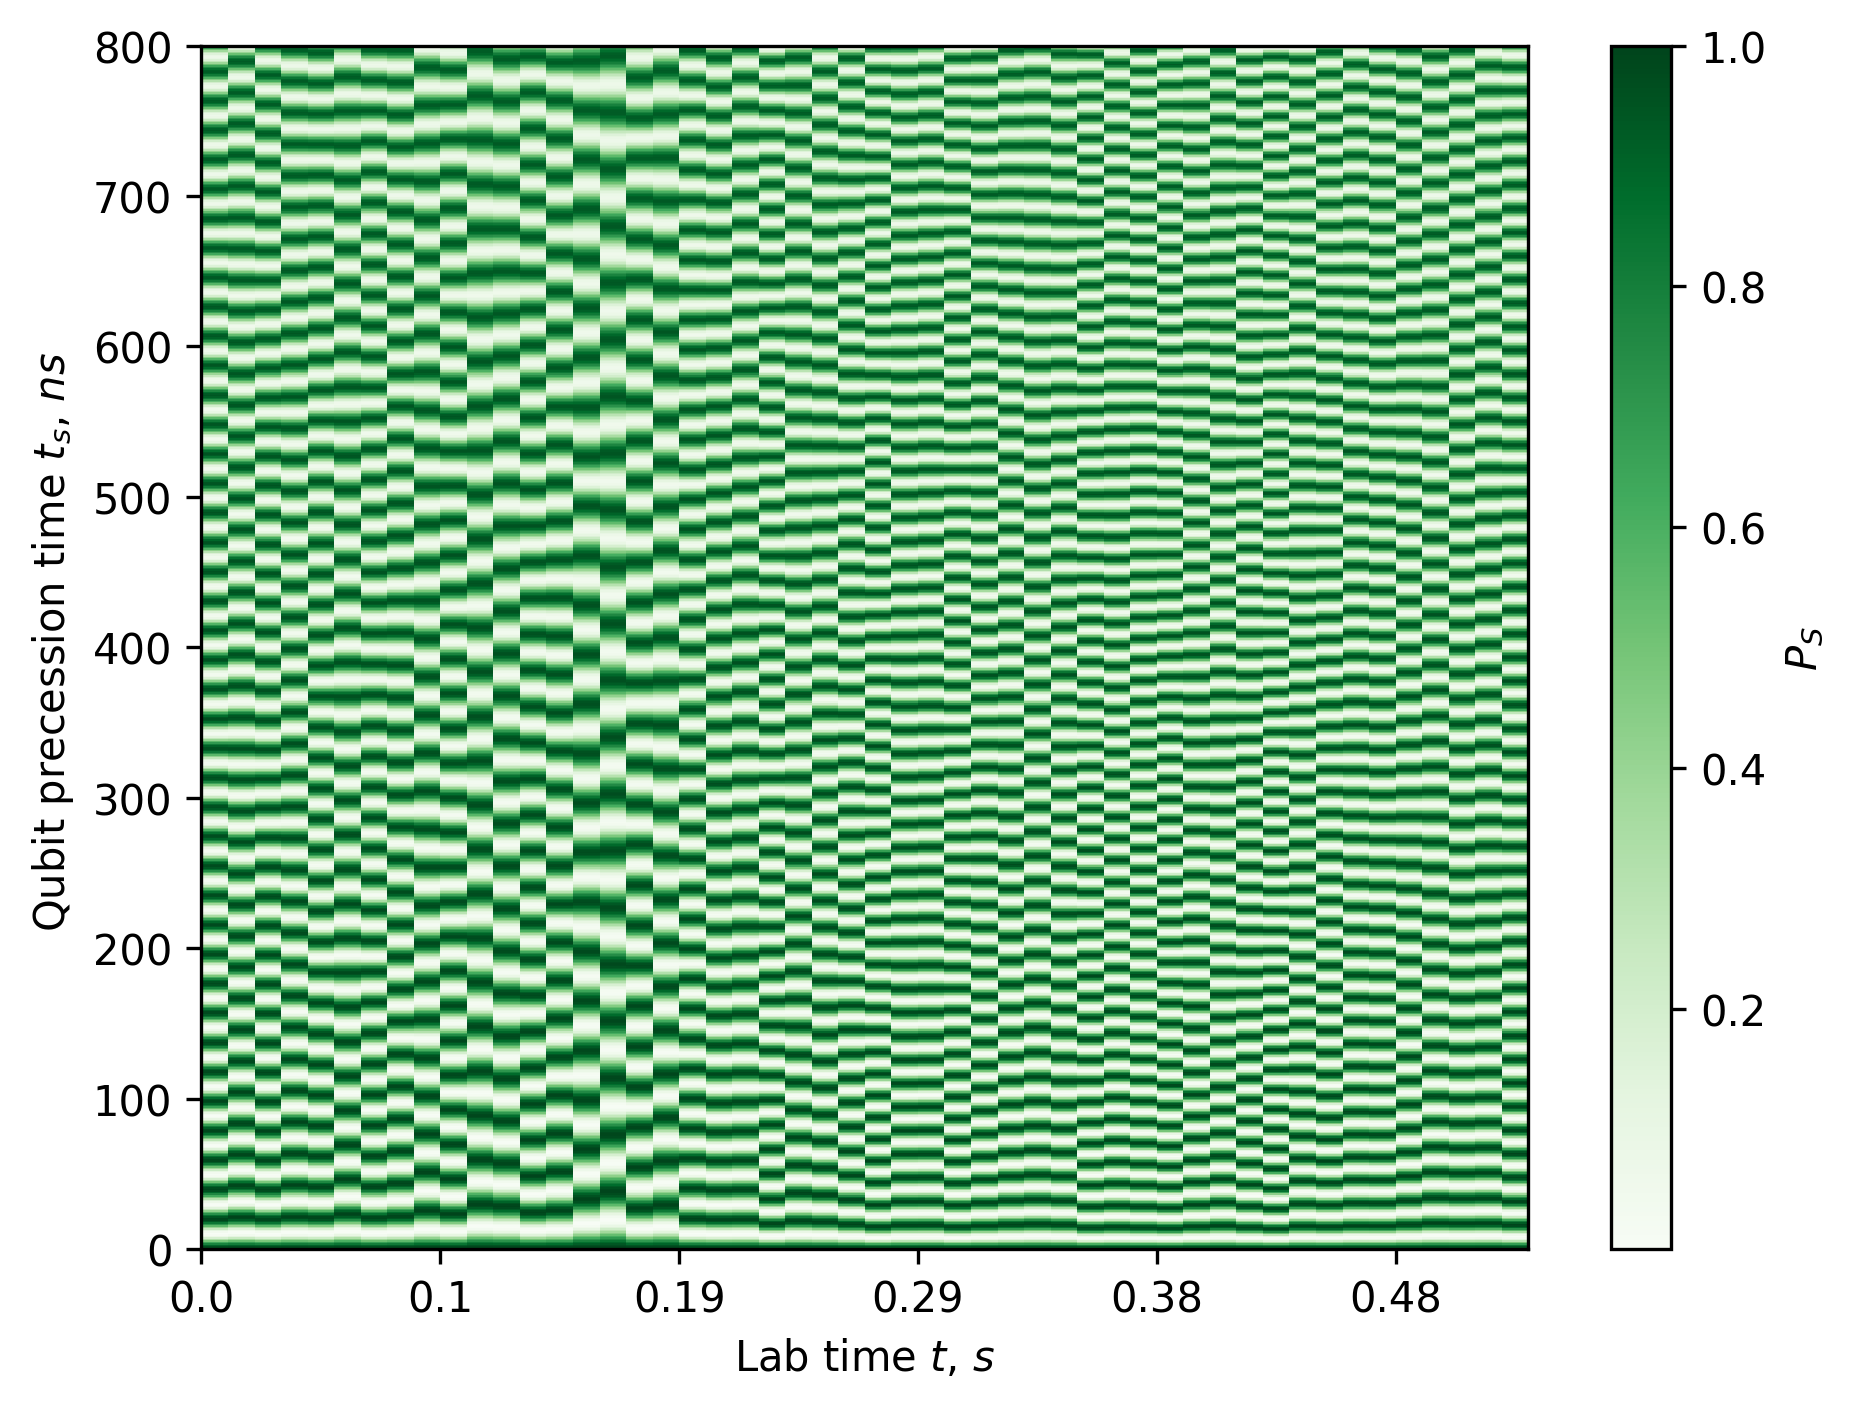

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=1, dpi=300)
ax1 = axes

single_figure = np.transpose(trace_tot[0:50])
im = ax1.pcolormesh(single_figure, cmap ='Greens')
ax1.set_xlabel(r"Lab time $t$, $s$ ")
ax1.set_ylabel(r" Qubit precession time $ t_s$, $ns$ ")

ax1.set_xticks(np.arange(0, 50, 9))
ax1.set_xticklabels(np.round(tf[0:50:9],2))
cbar = plt.colorbar(im)
cbar.set_label('$P_S$')

plt.tight_layout()
plt.show()

### 1.3. Prepare data <a class="anchor" id="Step_3"></a>
- We prepare the data into the dataset format that can be easily applied to the NN model.

In [ ]:
NUM_HAMILTONIAN = delta_tot.shape[0] # number of different delta B field.
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class datafunc():
    ### Class that handles the data

    def __init__(self, NUM_HAMILTONIAN):
        ### we input the number of Hamiltonians when initializing the class
        self.NUM_HAMILTONIAN = NUM_HAMILTONIAN

        ### combine the label and training data
        self.training_data = []  # empty list, will populate data and labels later on.

    def make_training_data(self):
        for H_no in range(self.NUM_HAMILTONIAN): # for each Hamiltonian
            delta_b_temp = delta_tot[H_no]
            trace_temp = trace_tot[H_no]

            self.training_data.append([ delta_b_temp, trace_temp.flatten() ])

        np.random.shuffle(self.training_data)
        np.save("{}/training_data.npy".format(directory), self.training_data)

if REBUILD_DATA:
    dataclass = datafunc(NUM_HAMILTONIAN)
    dataclass.make_training_data()

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
### load the above made training data:
training_data = np.load("{}/training_data.npy".format(directory), allow_pickle=True)
training_data.shape

(15000, 2)

In [ ]:
### The function that takes our training and labeled data and create a custom dataset class and passed on to the dataloader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        ### we pass data and labels when we initialize the class
        self.data = data
        self.labels = labels

    def __len__(self):
        ### function that outputs length of dataset
        return len(self.data)

    def __getitem__(self, idx):
        ### function that outputs data item with index idx
        data_idx = self.data[idx]
        label = self.labels[idx]

        return data_idx, label

In [ ]:
### convert the loaded data into torch tensor objects:

### X is the time evolution of population:
training_data = np.array(training_data)
X = torch.Tensor([i[1] for i in training_data])
### y is the value of B field:
y = torch.Tensor([convb(i[0]) for i in training_data])

#### Separate training and test data:
TEST_PCT = 0.2     # reserve 20% of our data for the validation set
test_size = int(len(X)*TEST_PCT)
print(test_size)

### separate the date into training data and test data:
train_X = X[:-test_size]
train_y= y[:-test_size]
test_X = X[-test_size:]
test_y = y[-test_size:]

print("len(train_X), len(test_y) is ", len(train_X), len(test_X))

### Make dataset class:
train_dataset_class = CustomDataset(train_X, train_y)
test_dataset_class = CustomDataset(test_X, test_y)

### we pass the dataset as an argument to DataLoader -> automatic batching, sampling, shuffling etc.
batch_size = 250

### create data loaders
train_dataloader = DataLoader(train_dataset_class, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset_class, batch_size = batch_size)

### check that the dataloader works correctly and give the right shape and type
for X, y in train_dataloader:
    print(f"Shape of X: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

3000
len(train_X), len(test_y) is  12000 3000
Shape of X: torch.Size([250, 800]) torch.float32
Shape of y: torch.Size([250]) torch.float32


### 1.4. Setup the model <a class="anchor" id="Step_4"></a>

In [ ]:
### Build the neural network class:

class DenseNeuralNetwork(nn.Module):

    def __init__(self):
        super(DenseNeuralNetwork,self).__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(800,400),
            nn.ReLU(),
            nn.Linear(400,200),
            nn.ReLU(),
            nn.Linear(200,1),
        )

    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

- Everytime you want to restart the training, you should initialize the model again:

In [ ]:
### here we initialize an instance of the class
model = DenseNeuralNetwork().to(device)
### print the status of the model
print(model)

### print the number of trainableparameters:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {pytorch_total_params}")

DenseNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)
Trainable params: 400801


### 1.5. Train the model <a class="anchor" id="Step_5"></a>

Finally we are ready to train our model. Here we basically just need to feed the dataset to our model, and the model will minimise the loss function we chose and update the model parameters according to the optimization method we specified.

The last thing we need to choose is the number of epochs and the batch_size.


*   batch_size: this is the number of images we feed to our model in 1 iteration
*   epochs: the number of times we run through our data set.

Let's suppose batch size = 250. Then the training proceeds as follows:

1.   Divide our dataset in batches of 250.
2.   Take a batch of 250 samples and feed it to the model. This gives 250 output vectors from which we compute the loss function and its gradient w.r.t. to model parameters.
3. Use the gradients to update the model parameters according to the optimizer we chose
4. Repeat steps 2 and 3 until we have cycled through to the end of the dataset. This will be the end of one epoch.

Number of iterations in one epoch = size of data set / batch_size


A few comments:

* The smaller the batch size, the faster the model trains.
* The smaller the batch size, the more noisy the training will be.
* Some amount of noise is useful to prevent us from getting stucked in local minima.

In [ ]:
### Initialize the loss function and the optimizer:
learning_rate=1e-3

loss_fn = nn.MSELoss() # we use the mean squared error (squared L2 norm)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) # The optimizer is Adam

### define the train and test loss accumulation
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [ ]:
### define training function: make predicition on data set batch,
### backpropagate the error and adjust model parameters

def train(dataloader, model, loss_fn, optimizer, train_loss, train_acc):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)   # num of Hamiltonian samples
    model.train()
    running_loss, err = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        ### compute prediction error
        pred = model(X)
        loss = loss_fn(pred.flatten(),y.flatten())

        ### Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ### collect the accuracy:
        running_loss += loss.item()

        # consider absolute estimation error: error = abs(x_estimate - x_err)
        err += (torch.abs(pred.flatten()-y.flatten())/y.flatten()).sum().item()

        if batch % 25==0:
            loss,current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    running_loss /= num_batches
    err /= size
    train_acc.append(err)
    train_loss.append(running_loss)

### check performance against the test data set
def test(dataloader,model,loss_fn,test_loss, test_acc):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    running_loss, err = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            running_loss += loss_fn(pred.flatten(), y.flatten()).item()
            err += (torch.abs(pred.flatten()-y)/y).sum().item()
    running_loss /= num_batches
    err /= size
    test_acc.append(err)
    test_loss.append(running_loss)
    print(f"Test Error: \n Error {(100*err):>0.1f}%, Avg loss:{running_loss:>8f}\n")

In [ ]:
epochs = 15
### train the network:
for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------")
    train(train_dataloader,model,loss_fn,optimizer, train_loss , train_acc )
    test(test_dataloader,model,loss_fn, test_loss , test_acc )
print("Done!")

Epoch 1
 -------------------
loss: 35.257294 [    0/12000]
loss: 7.075996 [ 6250/12000]
Test Error: 
 Error 81.3%, Avg loss:6.919417

Epoch 2
 -------------------
loss: 7.091104 [    0/12000]
loss: 4.830121 [ 6250/12000]
Test Error: 
 Error 56.3%, Avg loss:2.888607

Epoch 3
 -------------------
loss: 3.162854 [    0/12000]
loss: 1.039335 [ 6250/12000]
Test Error: 
 Error 19.1%, Avg loss:0.620266

Epoch 4
 -------------------
loss: 0.441775 [    0/12000]
loss: 0.527974 [ 6250/12000]
Test Error: 
 Error 16.1%, Avg loss:0.405271

Epoch 5
 -------------------
loss: 0.242909 [    0/12000]
loss: 0.272000 [ 6250/12000]
Test Error: 
 Error 10.7%, Avg loss:0.253717

Epoch 6
 -------------------
loss: 0.117669 [    0/12000]
loss: 0.223767 [ 6250/12000]
Test Error: 
 Error 10.1%, Avg loss:0.213275

Epoch 7
 -------------------
loss: 0.104627 [    0/12000]
loss: 0.135470 [ 6250/12000]
Test Error: 
 Error 6.0%, Avg loss:0.136749

Epoch 8
 -------------------
loss: 0.039200 [    0/12000]
loss: 0.115

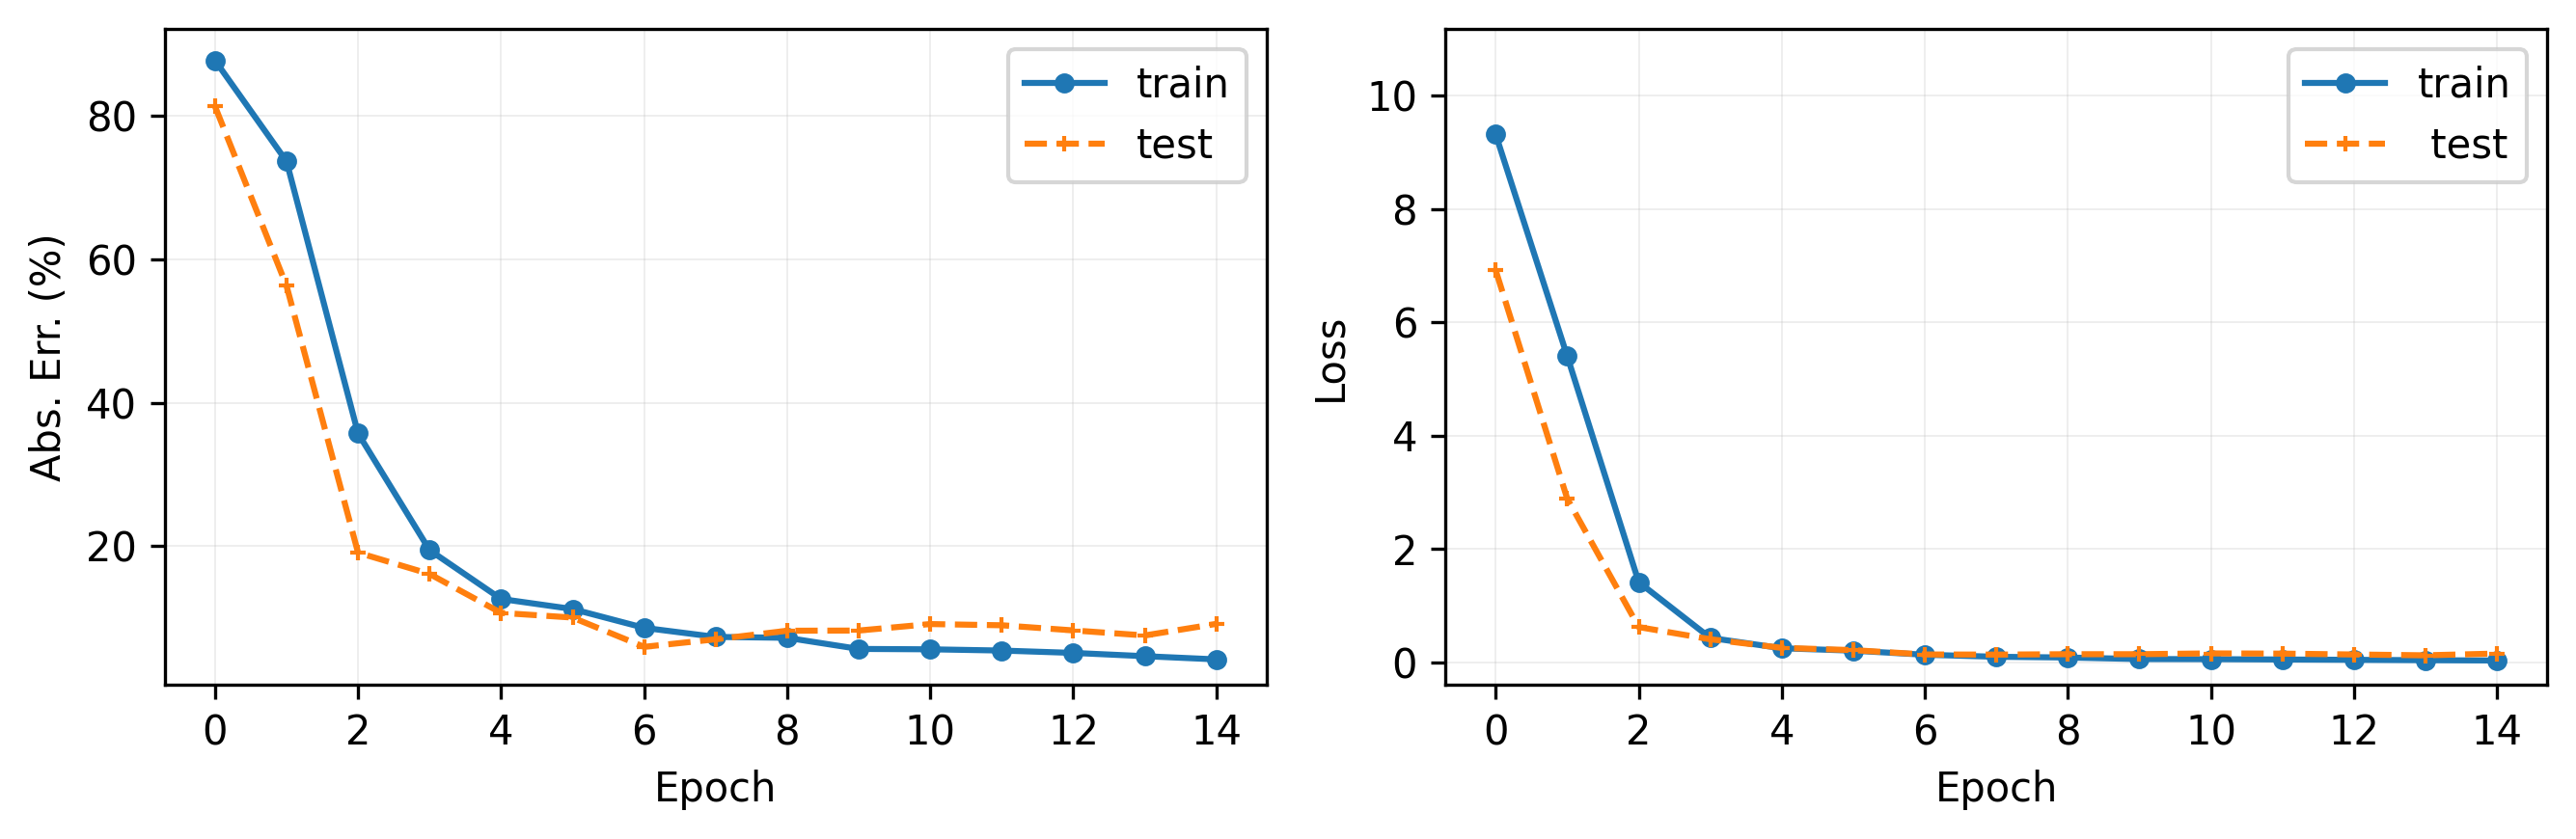

In [ ]:
### Plot the training and test loss and error duing the training:

def create_acc_loss_graph(train_acc,train_loss, test_acc, test_loss):
    fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
    fig.set_size_inches(9, 3)
    ax1, ax2 = axes[0], axes[1]

    train_accp  = np.array(train_acc)*100
    test_accp  = np.array(test_acc)*100
    ax1.plot(train_accp,'-o',label="train", markersize=4)
    ax1.plot(test_accp,'--+',label="test", markersize=4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Abs. Err. (%)')
    ax1.legend(loc=1)

    ax2.plot(train_loss,'-o',label="train", markersize=4)
    ax2.plot(test_loss,'--+',label=" test", markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc=1)

    #plot parameters
    ax1.set_ylim(np.min([np.min(train_accp),np.min(test_accp)])*0.16, np.max([np.max(train_accp),np.max(test_accp)])*1.05)
    ax2.set_ylim(-0.4, np.max([np.max(train_loss),np.max(test_loss)])*1.2)
    ax1.grid(True, which='both',linewidth=0.1)
    ax2.grid(True, which='both',linewidth=0.1)
    plt.tight_layout()
    plt.show()
create_acc_loss_graph(train_acc ,train_loss , test_acc , test_loss )

### 1.6.  Interpretation and analysis <a class="anchor" id="Step_6"></a>
- Let's plot the prediction vs true B field:

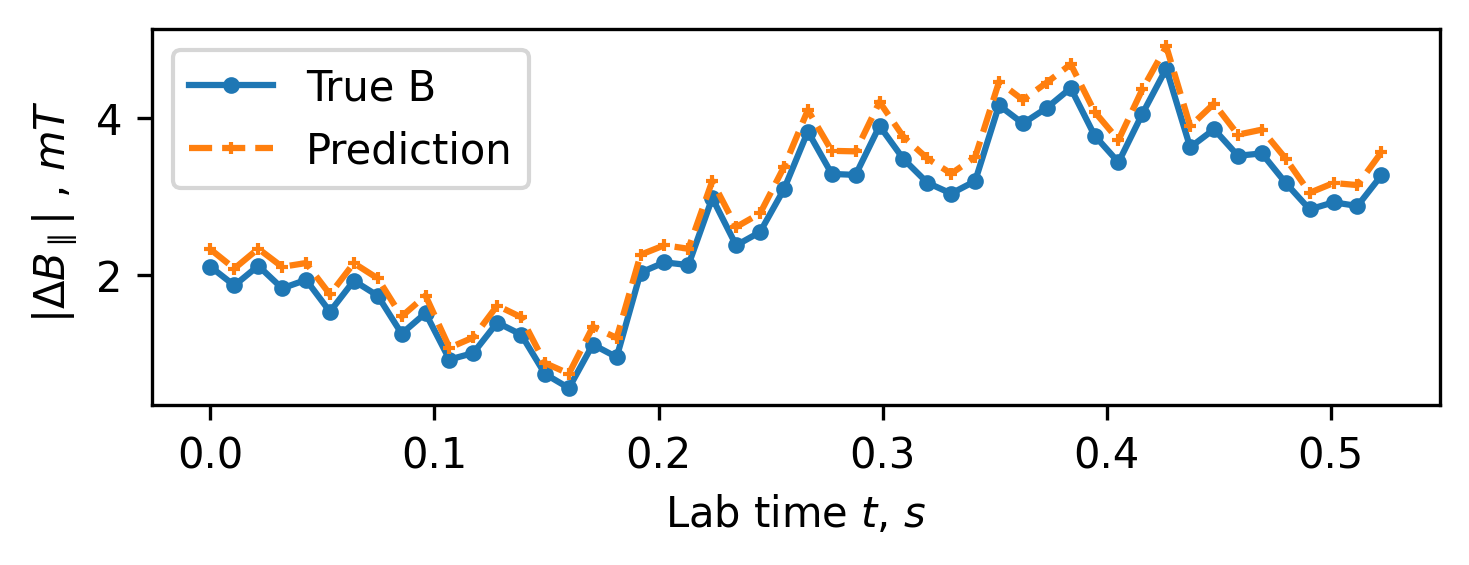

In [ ]:
N = 50 # number of B fields = number of lab time steps
x = torch.Tensor(trace_tot[0:N])
fig, axes = plt.subplots(ncols=1, nrows=1, dpi=300)
fig.set_size_inches(5, 2)
ax1 = axes
ax1.plot(tf[0:N],convb(delta_tot)[0:N],'-o',label="True B", markersize=3)
ax1.plot(tf[0:N],model(x).detach().numpy(),'--+',label="Prediction", markersize=3)
ax1.set_xlabel(r"Lab time $t$, $s$ ")
ax1.set_ylabel(r" $|\Delta B _{\parallel}|$ , $mT$ ")
ax1.legend(loc=2)
plt.tight_layout()
plt.show()

## 2. Exercise: open question: using the time series and predict the next value of Overhauser field <a class="anchor" id="part2"></a>

In the above plot, we plot the time evolution of the Overhauser field. Note that we only use the NN model to predict each single value of Overhauser field from a column of singlet return probability $P_S$.
- Forget about the singlet return probability $P_S$, can you make use of the time evolution of the Overhauser field? More specifically, we would like to input a time series of Overhauser field and output the value of Overhauser field at the next time step.
- you can make use of a more advanced method like:
    - Bayesian [see Nature Communications volume 5, Article number: 5156 (2014)]
        - Here you will use Bayesian inference method to take the previous time step value as the observation, and out put the value at next step, given the 50 previous steps.
    - RNN for instance [https://pytorch.org/docs/stable/generated/torch.nn.RNN.html]
        - RNN gives you a use of internal state (memory) so you can take advantage of previous time steps.

In [ ]:
## Load the data:
delta_tot = np.load('{}/delta_tot.npy'.format(directory)) # total true Delta B
tf = np.load('{}/time_steps.npy'.format(directory))  # lab time

In [ ]:
delta_tot.shape

(15000,)

- For example, we use 50 steps of time evolution of Overhauser field, and out put the value at step 51

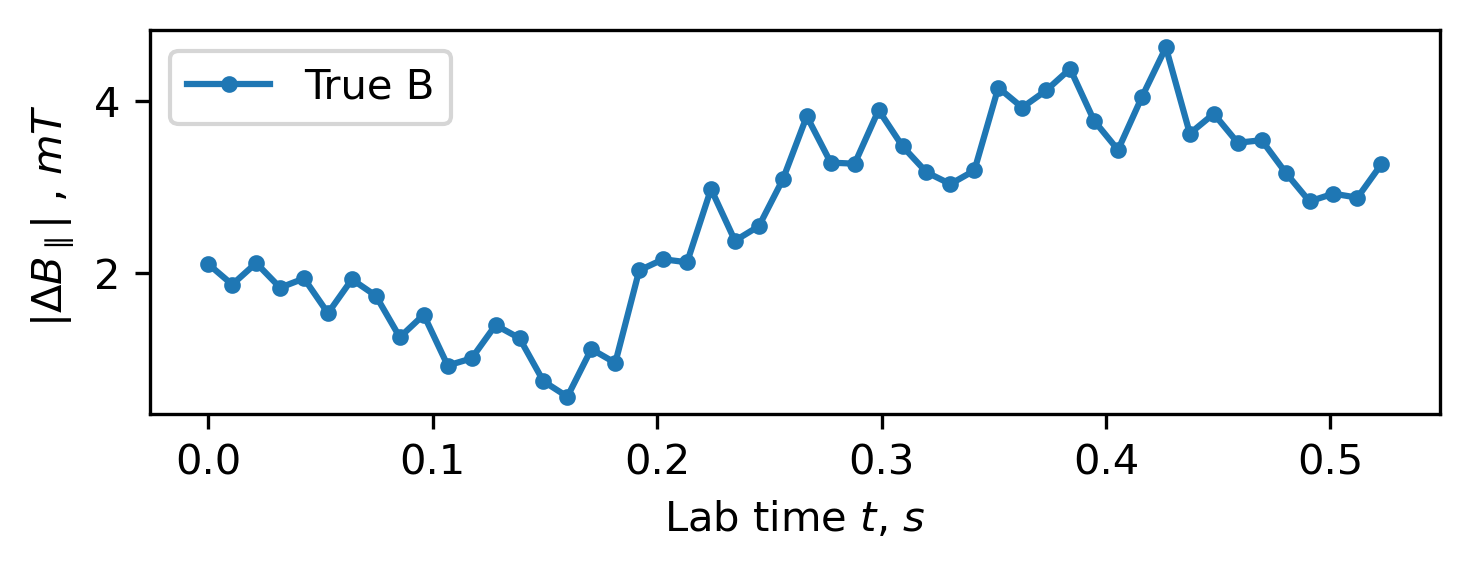

In [ ]:
N = 50 # number of B fields = number of lab time steps
x = torch.Tensor(trace_tot[0:N])
fig, axes = plt.subplots(ncols=1, nrows=1, dpi=300)
fig.set_size_inches(5, 2)
ax1 = axes
ax1.plot(tf[0:N],convb(delta_tot)[0:N],'-o',label="True B", markersize=3)
ax1.set_xlabel(r"Lab time $t$, $s$ ")
ax1.set_ylabel(r" $|\Delta B _{\parallel}|$ , $mT$ ")
ax1.legend(loc=2)
plt.tight_layout()
plt.show()